In [1]:
import rebound
import scipy.integrate as integrate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
def slicePlot(data, axes = None):
    if axes == None:
        gs = gridspec.GridSpec(2, 2)
        ax1 = plt.subplot(gs[1, 0])
        ax2 = plt.subplot(gs[0, 0])
        ax3 = plt.subplot(gs[1, 1])
    else:
        ax1, ax2, ax3 = axes
    
    c = ax1.plot(data[:, 0], data[:, 1])[0].get_color()
    ax1.plot(data[0, 0], data[0, 1], 'o', c = c, alpha = 0.5)
    ax1.plot(data[-1, 0], data[-1, 1], 'o', c = c, alpha = 0.7)
    ax1.plot([0], [0], 'o')
    ax2.plot(data[:, 0], data[:, 2])
    ax3.plot(data[:, 2], data[:, 1])

    ax2.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    ax2.set_ylabel('$z$')
    ax3.set_xlabel('$z$')
    
    return (ax1, ax2, ax3)

class Particle(object):
    def __init__(self, simulation_particle):
        self.simulation_particle = simulation_particle
        
        self.positions = []
        self.speeds = []
        
    def savePosition(self):
        self.positions += [self.simulation_particle.xyz]
        
    def saveSpeeds(self):
        self.speeds += [self.simulation_particle.vxyz]
        
    def saveState(self):
        self.savePosition()
        self.saveSpeeds()
        
    def getPositions(self):
        if type(self.positions) is list:
            self.positions = np.array(self.positions)
        return self.positions
    
    def getSpeeds(self):
        if type(self.speeds) is list:
            self.speeds = np.array(self.speeds)
        return self.speeds

# Gaussian distribution of mass

For a gaussian symmetric mass distribution:

$$
    m(\vec{r}) \propto e^{-\alpha r^2} \qquad \text{Where $\alpha$ determines how fast mass decays with distance}
$$

Normalizing:

$$
    \int\limits_0^\infty e^{-\alpha r^2}dr = \dfrac{1}{2}\sqrt{\dfrac{\pi}{\alpha}}
$$

$$
    m(\vec{r}) \propto 2\sqrt{\dfrac{\alpha}{\pi}} e^{-\alpha r^2}
$$

Considering an arbitraty total mass $m_T$:
$$
    m(\vec{r}) = 2 m_t \sqrt{\dfrac{\alpha}{\pi}} e^{-\alpha r^2}
$$

A body at a point $\vec{r}$ will feel the mass of all the bodies in a radius $r$ as if it was in the center of mass.
$$
    M_h(\vec{r}) = \int\limits_0^{r} m(\vec{r}) d\vec{r}
$$

In [4]:
def gaussianMass(r, total_mass = 100, alpha = 0.1):
    factor = 0.5 * (np.pi / alpha) ** 0.5
    r2 = r * r    
    return total_mass * np.exp(- alpha * r2) / factor

def massAtR(function, r):
    return integrate.quad(function, 0, r)[0]

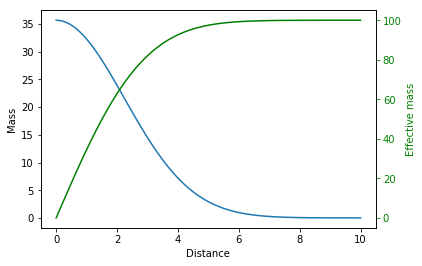

In [5]:
xs = np.linspace(0, 10, 100)
masses = gaussianMass(xs)

masses_integrated = [massAtR(gaussianMass, r) for r in xs]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(xs, masses)
ax2.plot(xs, masses_integrated, c = 'g')

ax1.set_ylabel('Mass')
ax2.set_ylabel('Effective mass', color = 'g')
ax1.set_xlabel('Distance')

ax2.tick_params('y', colors = 'g')

plt.show()

# Rebound simulation
The force for a single body will be given by:
$$
    \ddot{\vec{x}} = -\dfrac{GM_h(x)}{x^2}\hat{x}
$$

In [6]:
def additional_force(sim, epsilon = 0.01):
    global particle, G
    pos = np.array(particle.xyz)
    r = sum(pos ** 2 + epsilon) ** 0.5
    coeff = G * massAtR(gaussianMass, r) / (r ** 2)
    dir_ = pos / r
    
    particle.ax -= coeff * dir_[0]
    particle.ay -= coeff * dir_[1]
    particle.az -= coeff * dir_[2]

In [14]:
sim = rebound.Simulation()
sim.add(m = 1.0e-5, x = 0, y = 1, z = 0, vx = 10)

dt = 0.01
G = 1
particle = sim.particles[0]
sim.additional_forces = additional_force

In [15]:
n_points = 1000

times = np.zeros(n_points)
positions = np.zeros((n_points, 3))
speeds = np.zeros((n_points, 3))

In [17]:
def do():
    for i in range(n_points):
        times[i] = times[i - 1] + dt
        sim.integrate(times[i], exact_finish_time = 0) # integrate to the nearest timestep so WHFast's timestep stays constant
        positions[i] = particle.xyz
        speeds[i] = particle.vxyz

In [20]:
%%time
do()

CPU times: user 729 ms, sys: 0 ns, total: 729 ms
Wall time: 731 ms


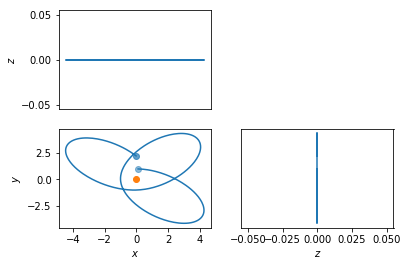

In [10]:
axes = slicePlot(positions)

$$
    \ddot{\vec{x}} = \left(-\dfrac{GM_h(x)}{x^2} + a_{DF}-\ddot{x}\dfrac{\dot{M_\bullet}}{M_\bullet} -qH^2x\right)\hat{x}
$$